ресурс: https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/data

# Setup & Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded.")

Libraries loaded.


# Load Dataset

In [3]:
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Data Understanding and Preprocessing

In [ ]:
# Basic information
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])
print(f"\nTotal missing: {missing.sum()} ({missing.sum()/len(df)*100:.2f}%)")

# Display first few rows
print("\n" + "=" * 80)
print("FIRST 5 ROWS")
print("=" * 80)
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

## Data Preprocessing

### 1. Handle Missing Values
### 2. Encode Categorical Variables
### 3. Feature Selection
### 4. Scaling


In [ ]:
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

# Make a copy for preprocessing
df_processed = df.copy()

print("=" * 80)
print("STEP 1: HANDLING MISSING VALUES")
print("=" * 80)

# 1. Handle missing values in loan_int_rate (3116 missing)
print("\nHandling loan_int_rate missing values:")
print(f"  Missing: {df_processed['loan_int_rate'].isnull().sum()} ({df_processed['loan_int_rate'].isnull().sum()/len(df_processed)*100:.2f}%)")

# Strategy: Fill with median grouped by loan_grade (grade affects interest rate)
loan_int_rate_median = df_processed.groupby('loan_grade')['loan_int_rate'].median()
print(f"  Median by loan_grade: {loan_int_rate_median.to_dict()}")

# Fill missing values with median by loan_grade
df_processed['loan_int_rate'] = df_processed.groupby('loan_grade')['loan_int_rate'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing (e.g., if a grade has all missing), fill with overall median
df_processed['loan_int_rate'] = df_processed['loan_int_rate'].fillna(df_processed['loan_int_rate'].median())

print(f"  After imputation - Missing: {df_processed['loan_int_rate'].isnull().sum()}")

# 2. Handle missing values in person_emp_length (895 missing)
print("\nHandling person_emp_length missing values:")
print(f"  Missing: {df_processed['person_emp_length'].isnull().sum()} ({df_processed['person_emp_length'].isnull().sum()/len(df_processed)*100:.2f}%)")

# Strategy: Fill with median grouped by person_age (employment length may vary by age)
person_emp_length_median = df_processed.groupby(df_processed['person_age'] // 10 * 10)['person_emp_length'].median()
print(f"  Median by age group: {person_emp_length_median.to_dict()}")

# Fill missing values with median by age group
df_processed['person_emp_length'] = df_processed.groupby(df_processed['person_age'] // 10 * 10)['person_emp_length'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing, fill with overall median
df_processed['person_emp_length'] = df_processed['person_emp_length'].fillna(df_processed['person_emp_length'].median())

print(f"  After imputation - Missing: {df_processed['person_emp_length'].isnull().sum()}")

# Verify no missing values remain
print(f"\n✓ Total missing values after imputation: {df_processed.isnull().sum().sum()}")


In [ ]:
# ============================================================================
# STEP 2: ENCODE CATEGORICAL VARIABLES
# ============================================================================

print("=" * 80)
print("STEP 2: ENCODING CATEGORICAL VARIABLES")
print("=" * 80)

# 1. person_home_ownership: RENT, OWN, MORTGAGE, OTHER
print("\n1. person_home_ownership:")
print(f"   Values: {df_processed['person_home_ownership'].value_counts().to_dict()}")
# One-hot encoding (or ordinal if there's a logical order)
# Using one-hot encoding for better model performance
df_processed = pd.get_dummies(df_processed, columns=['person_home_ownership'], prefix='home_own')
print(f"   ✓ Encoded with one-hot encoding")

# 2. loan_intent: PERSONAL, EDUCATION, MEDICAL, VENTURE, HOMEIMPROVEMENT, DEBTCONSOLIDATION
print("\n2. loan_intent:")
print(f"   Values: {df_processed['loan_intent'].value_counts().to_dict()}")
# One-hot encoding
df_processed = pd.get_dummies(df_processed, columns=['loan_intent'], prefix='intent')
print(f"   ✓ Encoded with one-hot encoding")

# 3. loan_grade: A, B, C, D, E, F, G (ordinal - A is best, G is worst)
print("\n3. loan_grade:")
print(f"   Values: {df_processed['loan_grade'].value_counts().to_dict()}")
# Ordinal encoding (A=1, B=2, ..., G=7) - lower is better
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_processed['loan_grade_encoded'] = df_processed['loan_grade'].map(grade_mapping)
df_processed = df_processed.drop('loan_grade', axis=1)  # Drop original column
print(f"   ✓ Encoded with ordinal encoding: {grade_mapping}")

# 4. cb_person_default_on_file: Y, N (binary)
print("\n4. cb_person_default_on_file:")
print(f"   Values: {df_processed['cb_person_default_on_file'].value_counts().to_dict()}")
# Binary encoding: Y=1, N=0
df_processed['cb_person_default_on_file'] = (df_processed['cb_person_default_on_file'] == 'Y').astype(int)
print(f"   ✓ Encoded as binary: Y=1, N=0")

print(f"\n✓ All categorical variables encoded")
print(f"  New shape: {df_processed.shape}")
print(f"  New columns: {df_processed.columns.tolist()}")


In [ ]:
# ============================================================================
# STEP 3: FEATURE SELECTION
# ============================================================================

print("=" * 80)
print("STEP 3: FEATURE SELECTION")
print("=" * 80)

from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

# Prepare features and target
X = df_processed.drop('loan_status', axis=1)
y = df_processed['loan_status']

print(f"\nOriginal features: {X.shape[1]}")
print(f"Features: {X.columns.tolist()}")

# Calculate Mutual Information
print("\nCalculating Mutual Information scores...")
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nMutual Information Scores (Top 15):")
print(mi_df.head(15).to_string(index=False))

# Select top k features based on mutual information
# Select features with MI > 0.01 (threshold) or top 20 features
k_best = min(20, len(X.columns))
threshold = 0.01
selected_features = mi_df[mi_df['MI_Score'] > threshold]['Feature'].tolist()

# If we have fewer than 10 features above threshold, take top k
if len(selected_features) < 10:
    selected_features = mi_df.head(k_best)['Feature'].tolist()

print(f"\n✓ Selected {len(selected_features)} features (MI > {threshold} or top {k_best})")
print(f"Selected features: {selected_features}")

# Update X with selected features
X_selected = X[selected_features].copy()

print(f"\nFinal feature set shape: {X_selected.shape}")


In [ ]:
# ============================================================================
# STEP 4: TRAIN/TEST SPLIT AND SCALING
# ============================================================================

print("=" * 80)
print("STEP 4: TRAIN/TEST SPLIT AND SCALING")
print("=" * 80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

# Apply Standard Scaling
print("\nApplying StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Data scaled and ready for modeling")
print(f"  Scaled train shape: {X_train_scaled.shape}")
print(f"  Scaled test shape: {X_test_scaled.shape}")


# Target Distribution

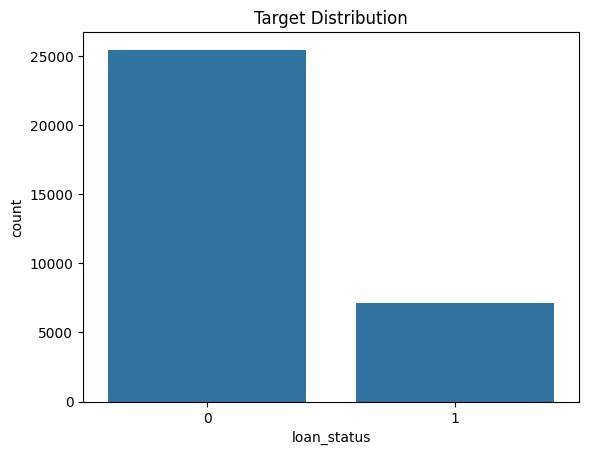

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

In [7]:
sns.countplot(x=df['loan_status'])
plt.title("Target Distribution")
plt.show()

df['loan_status'].value_counts(normalize=True)

# Mutual Information

In [8]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop("loan_status", axis=1)
y = df["loan_status"]

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

mi_series.head(10)

ValueError: could not convert string to float: 'RENT'

# Skewness & Log Transform

In [ ]:
skewed = X.skew().sort_values(ascending=False)
skewed.head(10)

for col in skewed.index[:6]:
    df[col] = np.log1p(df[col])

NameError: name 'X' is not defined

# Train/Test Split

In [ ]:
features = [col for col in df.columns if col != "flag_overdue"]

X = df[features]
y = df["flag_overdue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

# Model building

## Logstic regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(class_weight="balanced", max_iter=500)
lr.fit(X_train_scaled, y_train)

lr_pred = lr.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, lr_pred))
print("F1:", f1_score(y_test, lr_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

## Random Forest Model

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1:", f1_score(y_test, rf_pred))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

## XGBoost Baseline

In [ ]:
xgb = XGBClassifier(
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=3
)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("F1:", f1_score(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

# Model Tunning



In [ ]:
# results of best model
print("Accuracy:", accuracy_score(y_test, tuned_pred))
print("F1:", f1_score(y_test, tuned_pred))
print("ROC AUC:", roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]))

# Feature Importance

In [ ]:
importances = best_xgb.feature_importances_ #best model choice
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title("Top Predictive Features")
plt.show()